# Energy Prices Prediction

By: Alain Grullón

## 1. Import Necessary Libraries

In [3]:
#load important libraries
import numpy as np
import pandas as pd
import pandas_profiling
import datetime
import math as m
import scipy

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ML libraries
import os
from sklearn import svm
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer, OneHotEncoder

#import necessary libraries
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute  import SimpleImputer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Imputation
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer


# styling
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size
plt.style.use("fivethirtyeight")
sns.set_style('whitegrid')
sns.set_context('talk')

In [4]:
random_state = 0

## Reading in Train Set

In [5]:
train_df = pd.read_csv("power_market.csv", parse_dates = ["date"])
train_df.head()

,fc_demand,fc_nuclear,import_FR,export_FR,fc_wind,fc_solar_pv,fc_solar_th,price,date,hour
0,24400.0,7117.2,3000.0,2600.0,1732.0,0.0,5.1,58.82,2017-01-01,0
1,23616.0,7117.2,3000.0,2650.0,1826.0,0.0,0.6,58.23,2017-01-01,1
2,21893.0,7117.2,3000.0,2650.0,1823.0,0.0,4.6,51.95,2017-01-01,2
3,20693.0,7117.2,3000.0,2650.0,1777.0,0.0,9.7,47.27,2017-01-01,3
4,19599.0,7117.2,3000.0,2650.0,1746.0,0.0,24.1,45.49,2017-01-01,4


## EDA

In [6]:
# #import warnings
# import warnings 
# warnings.filterwarnings('ignore')

# report = pandas_profiling.ProfileReport(train_df)
# report

In [7]:
train_df.shape

(32135, 10)

In [8]:
train_df.dtypes # Look at all variables and their data types

fc_demand             float64
fc_nuclear            float64
import_FR             float64
export_FR             float64
fc_wind               float64
fc_solar_pv           float64
fc_solar_th           float64
price                 float64
date           datetime64[ns]
hour                    int64
dtype: object

### Gain understanding of the target variable

In [9]:
print("The price ranges between " + 
      str(min(train_df["price"])) + " and " + 
      str(max(train_df["price"])) + " €/MWh")
print(train_df['fc_demand'].describe())

The price ranges between 0.03 and 101.99 €/MWh
count    32135.000000
mean     28475.593527
std       4686.675600
min      16372.000000
25%      24605.500000
50%      28446.000000
75%      32124.000000
max      41103.000000
Name: fc_demand, dtype: float64


In [10]:
price_curve = pd.DataFrame(train_df.groupby("hour", as_index=False)["price"].mean())

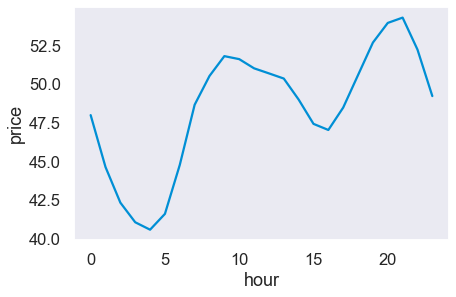

<Figure size 7200x7200 with 0 Axes>

In [11]:
sns.set_style('dark')

sns.lineplot(data=price_curve, 
           x='hour',
           y='price')
plt.figure(figsize=(100,100))
plt.show()

## Preprocessing

In [12]:
train_df.isnull().sum()

fc_demand       0
fc_nuclear      0
import_FR      13
export_FR      13
fc_wind         0
fc_solar_pv     0
fc_solar_th     0
price           0
date            0
hour            0
dtype: int64

In [13]:
train_df[train_df["import_FR"].isna()]

,fc_demand,fc_nuclear,import_FR,export_FR,fc_wind,fc_solar_pv,fc_solar_th,price,date,hour
840,26030.0,7117.2,NaN,NaN,12401.0,0.0,8.7,35.11,2017-02-05,0
1992,27245.0,7117.2,NaN,NaN,5702.0,0.0,67.0,40.00,2017-03-25,0
4847,28833.0,6105.9,NaN,NaN,3759.0,0.0,589.2,55.00,2017-07-22,0
6863,24622.0,6508.5,NaN,NaN,1901.0,0.0,60.0,64.46,2017-10-14,0
6887,23648.0,6508.5,NaN,NaN,4735.0,0.0,26.3,60.43,2017-10-15,0
10560,27850.0,6071.9,NaN,NaN,9924.0,0.0,41.1,41.71,2018-03-17,0
11303,26404.0,5066.1,NaN,NaN,5190.0,0.0,520.3,44.54,2018-04-17,0
15599,23272.0,7117.2,NaN,NaN,5096.0,0.0,41.1,64.45,2018-10-13,0
15623,23004.0,7117.2,NaN,NaN,9779.0,0.0,148.4,54.47,2018-10-14,0
19464,26352.0,7117.2,NaN,NaN,3177.0,0.0,419.1,55.26,2019-03-23,0


Missing values for import and export are both sporadic and therefore a ffill might be best, since the values from the previous hour may be the best predictor for the values of the current hour. However, we will try which one is best. 

### Imputation Strategies

In [14]:
def ffill(X_col): 
    return X_col.fillna(method = 'ffill')

ffill_imp = FunctionTransformer(ffill)

In [15]:
knn_imp_def = KNNImputer(n_neighbors=5)
knn_imp = FunctionTransformer(knn_imp_def)

In [16]:
simp_imp_def = SimpleImputer(missing_values = np.NaN, strategy = 'median')
simp_imp = FunctionTransformer(simp_imp_def)

#### Imputing date columns

In [17]:
#define function to round datetime to the nearest hour
def rounder(t):
    if t.minute >= 30:
        return t.replace(second=0, microsecond=0, minute=0, hour=t.hour+1)
    else:
        return t.replace(second=0, microsecond=0, minute=0)

In [18]:
# pip install holidays

In [19]:
#define a function to create columns from the given datetime column
from datetime import date
import holidays
from astral import Astral                     # used for determining sunrise, sunset 

city_name = 'Madrid'
def DateColumnCreations(data) : 
    
    #date-time conversion
    data['date'] = pd.to_datetime(data.date)
    
    #create year column
    data['year'] = pd.DatetimeIndex(data['date']).year
    
    #create month column
    data['month'] = pd.DatetimeIndex(data['date']).month
    
    #create day column
    data['day'] = pd.DatetimeIndex(data['date']).day
    
    #create holiday column
    spain_holidays = holidays.Spain()

    data['holiday'] = data['date'].isin(spain_holidays).astype(int)
    
    #create weekday column
    data['weekday'] = pd.DatetimeIndex(data['date']).weekday
    
    #setting up
    astral = Astral()
    city = astral[city_name]
    
    for i,row in data.iterrows():
     
     #create working_day column - Monday until Friday
        if data.loc[i,'weekday'] > 4:
            data.at[i,'workingday'] = 0
        else:
            data.at[i,'workingday'] = 1
        
    #create weekend column - Saturday + Sunday
        if data.loc[i,'weekday'] > 4:
            data.at[i,'weekend'] = 1
        else:
            data.at[i,'weekend'] = 0
    
    #create Daylight column 
        sun = city.sun(local = True, date = data.loc[i,'date']) 
    
        if (data.loc[i,'hour'] >= rounder(sun['sunrise']).hour) and (data.loc[i,'hour'] <= rounder(sun['sunset']).hour):
            data.loc[i,'daylight'] = 1
        else: 
            data.loc[i,'daylight'] = 0

    #create peak hours weekend and weekday     
        if (data.loc[i, 'weekend'] == 1) & ( data.loc[i, 'hour'] in [12,13,14,15]):
            data.loc[i, "peak_weekend"] = 1 
        else: 
            data.loc[i, "peak_weekend"] = 0
    
        if (data.loc[i, 'workingday'] == 1) & ( data.loc[i, 'hour'] in [7,8,17,18,19]):
            data.loc[i, "peak_workingday"] = 1 
        else: 
            data.loc[i, "peak_workingday"] = 0
    
    return data

In [20]:
spain_holidays = holidays.Spain()
print(spain_holidays.get('01-01-2018'))

Año nuevo


In [21]:
DateColumnCreations_Imp = FunctionTransformer(DateColumnCreations)

#### Create all column transformers

In [22]:
# Change to ordinal encoder if makes sense
ct_ffill = ColumnTransformer([
   
    ("ffill_nulls" , ffill_imp, ['import_FR', 'export_FR',],),   #use ffill on all numeric columns 
    ('DateColumns',DateColumnCreations_Imp, ['date','hour'],)                       #create all new feature columns relating to date 
    
] ,remainder='passthrough')

In [23]:
# Change to ordinal encoder if makes sense
ct_knn = ColumnTransformer([
   
   ("ffill_nulls" , ffill_imp, ['import_FR', 'export_FR',],),   #use ffill on all numeric columns 
    ('DateColumns',DateColumnCreations_Imp, ['date','hour'],)   #create all new feature columns relating to date 
    
] ,remainder='passthrough')

In [24]:
# Change to ordinal encoder if makes sense
ct_simp = ColumnTransformer([
   
   ("ffill_nulls" , ffill_imp, ['import_FR', 'export_FR',],),   #use ffill on all numeric columns 
    ('DateColumns',DateColumnCreations_Imp, ['date','hour'],)                       #create all new feature columns relating to date 
    
] ,remainder='passthrough')

#### Transform the array created to DataFrame, rename and assign type

In [25]:
#function to cast transformed array to data frame, rename columns and assign variable types 

def NameColumns(data_df):
    #cast ct output to dataframe and name columns 
    data_df = pd.DataFrame(data_df)
    data_df.columns = ['import_FR', 'export_FR', 'date', 'hour',
                       'year','month','day','holiday', 'weekday','workingday', 'weekend', 
                       'daylight', 'peak_weekend', 'peak_workingday','fc_demand','fc_nuclear','fc_wind', 'fc_solar_pv',
                        'fc_solar_th', 'price',
                      ]
    return data_df

#### Select the ct to run

In [26]:
train_df = ct_ffill.fit_transform(train_df)

In [27]:
# train_df = ct_iter.fit_transform(train_df)

In [28]:
# train_df = ct_knn.fit_transform(train_df)

In [29]:
# train_df = ct_simp.fit_transform(train_df)

In [30]:
#rename columns 
train_df = NameColumns(train_df)
train_df.iloc[1951,:]

import_FR                         2600
export_FR                         1900
date               2017-03-23 00:00:00
hour                                 7
year                              2017
month                                3
day                                 23
holiday                              0
weekday                              3
workingday                           1
weekend                              0
daylight                             1
peak_weekend                         0
peak_workingday                      1
fc_demand                        29627
fc_nuclear                      7117.2
fc_wind                           6441
fc_solar_pv                      161.8
fc_solar_th                       29.9
price                            47.51
Name: 1951, dtype: object

In [31]:
train_df = train_df.drop(columns="date")

In [32]:
#check data types
train_df[['import_FR', 'export_FR', 'hour',
                       'year','month','day','holiday', 'weekday','workingday', 'weekend', 
                       'daylight', 'peak_weekend', 'peak_workingday','fc_demand','fc_nuclear','fc_wind', 'fc_solar_pv',
                        'fc_solar_th', 'price',]] = train_df[['import_FR', 'export_FR', 'hour',
                       'year','month','day','holiday', 'weekday','workingday', 'weekend', 
                       'daylight', 'peak_weekend', 'peak_workingday','fc_demand','fc_nuclear','fc_wind', 'fc_solar_pv',
                        'fc_solar_th', 'price',]].astype(float)

In [33]:
train_df.dtypes

import_FR          float64
export_FR          float64
hour               float64
year               float64
month              float64
day                float64
holiday            float64
weekday            float64
workingday         float64
weekend            float64
daylight           float64
peak_weekend       float64
peak_workingday    float64
fc_demand          float64
fc_nuclear         float64
fc_wind            float64
fc_solar_pv        float64
fc_solar_th        float64
price              float64
dtype: object

In [34]:
#check if all null values have been imputed
train_df.isnull().sum()

import_FR          0
export_FR          0
hour               0
year               0
month              0
day                0
holiday            0
weekday            0
workingday         0
weekend            0
daylight           0
peak_weekend       0
peak_workingday    0
fc_demand          0
fc_nuclear         0
fc_wind            0
fc_solar_pv        0
fc_solar_th        0
price              0
dtype: int64

In [35]:
train_df.shape

(32135, 19)

### Outliers Handling

In [ ]:
#create a boxplot to look for outliers in some weather columns
plt.figure(figsize=(15, 10))
sns.boxplot(data=train_df[['temp', 'windspeed', 'apparent_temp', 'humidity',]], # on vars of choice
            palette='pastel');
plt.title("Graphical outlier analysis for some weather variables");
sns.set(font_scale=1.5)

In [ ]:
#create a boxplot to look for outliers in some weather columns
plt.figure(figsize=(15, 10))
sns.boxplot(data=train_df[['temp', 'windspeed', 'apparent_temp', 'humidity',]], # on vars of choice
            palette='pastel');
plt.title("Graphical outlier analysis for some weather variables");
sns.set(font_scale=1.5)

In [ ]:
# var1 outlier detection
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

X = train_df[['humidity']]
cov =  LocalOutlierFactor().fit_predict(X)
out = cov
print('number of outliers:', (out==-1).sum())
train_df[(out==-1)].head(10)

In [ ]:
# var2 outlier detection
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

X = train_df[['humidity']]
cov =  LocalOutlierFactor().fit_predict(X)
out = cov
print('number of outliers:', (out==-1).sum())
train_df[(out==-1)].head(10)

In [ ]:
# var3 outlier detection
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

X = train_df[['humidity']]
cov =  LocalOutlierFactor().fit_predict(X)
out = cov
print('number of outliers:', (out==-1).sum())
train_df[(out==-1)].head(10)

### Dealing with Cyclical features

In [36]:
train_df['hr_sin'] = np.sin(train_df.hour*(2.*np.pi/24))
train_df['hr_cos'] = np.cos(train_df.hour*(2.*np.pi/24))
train_df['mnth_sin'] = np.sin((train_df.month-1)*(2.*np.pi/12))
train_df['mnth_cos'] = np.cos((train_df.month-1)*(2.*np.pi/12))

In [37]:
train_df.head()

,import_FR,export_FR,hour,year,month,day,holiday,weekday,workingday,weekend,...,fc_demand,fc_nuclear,fc_wind,fc_solar_pv,fc_solar_th,price,hr_sin,hr_cos,mnth_sin,mnth_cos
0,3000.0,2600.0,0.0,2017.0,1.0,1.0,0.0,6.0,0.0,1.0,...,24400.0,7117.2,1732.0,0.0,5.1,58.82,0.000000,1.000000,0.0,1.0
1,3000.0,2650.0,1.0,2017.0,1.0,1.0,0.0,6.0,0.0,1.0,...,23616.0,7117.2,1826.0,0.0,0.6,58.23,0.258819,0.965926,0.0,1.0
2,3000.0,2650.0,2.0,2017.0,1.0,1.0,0.0,6.0,0.0,1.0,...,21893.0,7117.2,1823.0,0.0,4.6,51.95,0.500000,0.866025,0.0,1.0
3,3000.0,2650.0,3.0,2017.0,1.0,1.0,0.0,6.0,0.0,1.0,...,20693.0,7117.2,1777.0,0.0,9.7,47.27,0.707107,0.707107,0.0,1.0
4,3000.0,2650.0,4.0,2017.0,1.0,1.0,0.0,6.0,0.0,1.0,...,19599.0,7117.2,1746.0,0.0,24.1,45.49,0.866025,0.500000,0.0,1.0


### Further Feature Engineering

## Reading in Test Set

In [38]:
test_df = pd.read_csv("scoring.csv", parse_dates = ["date"])
test_df.head()

,fc_demand,fc_nuclear,import_FR,export_FR,fc_wind,fc_solar_pv,fc_solar_th,date,hour
0,24744.0,7117.2,2300.0,1750.0,2751.0,0.0,627.1,2020-09-01,0
1,23426.0,7117.2,2300.0,2100.0,2452.0,0.0,606.6,2020-09-01,1
2,22597.0,7117.2,2300.0,2100.0,2060.0,0.0,528.3,2020-09-01,2
3,22285.0,7117.2,2300.0,2100.0,1736.0,0.0,598.5,2020-09-01,3
4,22192.0,7117.2,2300.0,2100.0,1322.0,0.0,474.9,2020-09-01,4


## EDA

In [39]:
# #import warnings
# import warnings 
# warnings.filterwarnings('ignore')

# report = pandas_profiling.ProfileReport(test_df)
# report

In [40]:
test_df.shape

(3673, 9)

In [41]:
test_df.dtypes # Look at all variables and their data types

fc_demand             float64
fc_nuclear            float64
import_FR              object
export_FR              object
fc_wind               float64
fc_solar_pv           float64
fc_solar_th           float64
date           datetime64[ns]
hour                    int64
dtype: object

## Preprocessing

In [42]:
test_df.isnull().sum()

fc_demand      0
fc_nuclear     0
import_FR      0
export_FR      0
fc_wind        0
fc_solar_pv    0
fc_solar_th    0
date           0
hour           0
dtype: int64

In [43]:
DateColumnCreations_Imp = FunctionTransformer(DateColumnCreations)

#### Select the ct to run

In [44]:
test_df = ct_ffill.fit_transform(test_df)

In [45]:
# test_df = ct_iter.fit_transform(test_df)

In [46]:
# test_df = ct_knn.fit_transform(test_df)

In [47]:
# test_df = ct_simp.fit_transform(test_df)

#### Transform the array created to DataFrame, rename and assign type

In [48]:
#function to cast transformed array to data frame, rename columns and assign variable types without the target variable price

def NameColumns(data_df):
    #cast ct output to dataframe and name columns 
    data_df = pd.DataFrame(data_df)
    data_df.columns = ['import_FR', 'export_FR', 'date', 'hour',
                       'year','month','day','holiday', 'weekday','workingday', 'weekend', 
                       'daylight', 'peak_weekend', 'peak_workingday','fc_demand','fc_nuclear','fc_wind', 'fc_solar_pv',
                        'fc_solar_th',
                      ]
    return data_df

#### Transform the array created to DataFrame, rename and assign type

In [49]:
#rename columns 
test_df = NameColumns(test_df)
test_df.iloc[0,:]

import_FR                       2300.0
export_FR                       1750.0
date               2020-09-01 00:00:00
hour                                 0
year                              2020
month                                9
day                                  1
holiday                              0
weekday                              1
workingday                           1
weekend                              0
daylight                             0
peak_weekend                         0
peak_workingday                      0
fc_demand                        24744
fc_nuclear                      7117.2
fc_wind                           2751
fc_solar_pv                          0
fc_solar_th                      627.1
Name: 0, dtype: object

In [50]:
#check data types
test_df[['import_FR', 'export_FR', 'hour',
                       'year','month','day','holiday', 'weekday','workingday', 'weekend', 
                       'daylight', 'peak_weekend', 'peak_workingday','fc_demand','fc_nuclear','fc_wind', 'fc_solar_pv',
                        'fc_solar_th',]] = train_df[['import_FR', 'export_FR', 'hour',
                       'year','month','day','holiday', 'weekday','workingday', 'weekend', 
                       'daylight', 'peak_weekend', 'peak_workingday','fc_demand','fc_nuclear','fc_wind', 'fc_solar_pv',
                        'fc_solar_th',]].astype(float)

In [51]:
test_df = test_df.drop(columns="date")

In [52]:
#check data types
test_df.dtypes

import_FR          float64
export_FR          float64
hour               float64
year               float64
month              float64
day                float64
holiday            float64
weekday            float64
workingday         float64
weekend            float64
daylight           float64
peak_weekend       float64
peak_workingday    float64
fc_demand          float64
fc_nuclear         float64
fc_wind            float64
fc_solar_pv        float64
fc_solar_th        float64
dtype: object

In [53]:
test_df.shape

(3673, 18)

### Outliers Handling

In [ ]:
#create a boxplot to look for outliers in some weather columns
plt.figure(figsize=(15, 10))
sns.boxplot(data=test_df[['temp', 'windspeed', 'apparent_temp', 'humidity',]], # on vars of choice
            palette='pastel');
plt.title("Graphical outlier analysis for some weather variables");
sns.set(font_scale=1.5)

In [ ]:
#create a boxplot to look for outliers in some weather columns
plt.figure(figsize=(15, 10))
sns.boxplot(data=test_df[['temp', 'windspeed', 'apparent_temp', 'humidity',]], # on vars of choice
            palette='pastel');
plt.title("Graphical outlier analysis for some weather variables");
sns.set(font_scale=1.5)

In [ ]:
# var1 outlier detection
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

X = test_df[['humidity']]
cov =  LocalOutlierFactor().fit_predict(X)
out = cov
print('number of outliers:', (out==-1).sum())
test_df[(out==-1)].head(10)

In [ ]:
# var2 outlier detection
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

X = test_df[['humidity']]
cov =  LocalOutlierFactor().fit_predict(X)
out = cov
print('number of outliers:', (out==-1).sum())
test_df[(out==-1)].head(10)

In [ ]:
# var3 outlier detection
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

X = test_df[['humidity']]
cov =  LocalOutlierFactor().fit_predict(X)
out = cov
print('number of outliers:', (out==-1).sum())
test_df[(out==-1)].head(10)

### Dealing with Cyclical features

In [54]:
test_df['hr_sin'] = np.sin(test_df.hour*(2.*np.pi/24))
test_df['hr_cos'] = np.cos(test_df.hour*(2.*np.pi/24))
test_df['mnth_sin'] = np.sin((test_df.month-1)*(2.*np.pi/12))
test_df['mnth_cos'] = np.cos((test_df.month-1)*(2.*np.pi/12))

In [55]:
test_df.head()

,import_FR,export_FR,hour,year,month,day,holiday,weekday,workingday,weekend,...,peak_workingday,fc_demand,fc_nuclear,fc_wind,fc_solar_pv,fc_solar_th,hr_sin,hr_cos,mnth_sin,mnth_cos
0,3000.0,2600.0,0.0,2017.0,1.0,1.0,0.0,6.0,0.0,1.0,...,0.0,24400.0,7117.2,1732.0,0.0,5.1,0.000000,1.000000,0.0,1.0
1,3000.0,2650.0,1.0,2017.0,1.0,1.0,0.0,6.0,0.0,1.0,...,0.0,23616.0,7117.2,1826.0,0.0,0.6,0.258819,0.965926,0.0,1.0
2,3000.0,2650.0,2.0,2017.0,1.0,1.0,0.0,6.0,0.0,1.0,...,0.0,21893.0,7117.2,1823.0,0.0,4.6,0.500000,0.866025,0.0,1.0
3,3000.0,2650.0,3.0,2017.0,1.0,1.0,0.0,6.0,0.0,1.0,...,0.0,20693.0,7117.2,1777.0,0.0,9.7,0.707107,0.707107,0.0,1.0
4,3000.0,2650.0,4.0,2017.0,1.0,1.0,0.0,6.0,0.0,1.0,...,0.0,19599.0,7117.2,1746.0,0.0,24.1,0.866025,0.500000,0.0,1.0


### Further Feature Engineering

## Modelling Strategies

### Create Train, Validation, Test Sets

In [80]:
#split dataset into target column and features df
X = train_df.drop(columns=["price"]) # any unwanted variable
y = train_df.loc[:,train_df.columns == "price"] #target column

#split data into train and test dataset using a test set of 25%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state = random_state)

# Create the X_test for testing
X_test = test_df

In [57]:
X_train.shape

(24101, 22)

In [58]:
X_val.shape

(8034, 22)

In [59]:
y_train.shape

(24101, 1)

In [60]:
y_val.shape

(8034, 1)

In [61]:
X_test.shape

(3673, 22)

In [81]:
y_train = y_train.values.ravel()

## Modelling

In [63]:
# Adjust imports depending on Classification or Regression

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor, StackingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

### Determining the best model to perform GridSearch on

In [64]:
rgr1 = RandomForestRegressor(random_state=random_state, 
                                 bootstrap=False, 
                                 max_depth=20, 
                                 max_features='log2',
                                 min_samples_leaf=3,
                                 n_estimators=500,)

rgr2 = XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.9573624460869667,
                              gamma=0.42182525088500594, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.06121799331489221,
                              max_delta_step=0, max_depth=14,
                              min_child_weight=1,
                              monotone_constraints='()', n_estimators=361,
                              n_jobs=0, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=0.8218382225810743, tree_method='exact',
                              validate_parameters=1, verbosity=None,)

rgr3 = ExtraTreesRegressor(random_state=random_state, 
                            n_estimators=199,
                            max_depth=18,
                            max_features='auto',
                            bootstrap=True, 
                            criterion='mse')

# rgr4 = GradientBoostingRegressor(random_state=random_state, 
#                                   n_estimators=100,
#                                   max_depth=20,
#                                   learning_rate = 0.0327282665819041)

# rgr5 = AdaBoostRegressor(n_estimators=100, 
#                           learning_rate=0.1,
#                           loss='linear',
#                           random_state=random_state)

rgr6 = BaggingRegressor(random_state=random_state,
                        base_estimator=rgr3,
                        n_estimators=10,
                        max_samples=1,
                        max_features=1,
                        bootstrap=True,)

In [62]:
pipe = Pipeline([
        ('RF', print("AVG RF R-squared of the 10 folds = {}".format(np.mean
                                                            (cross_val_score
                                                             (rgr1, 
                                                              X_train, y_train, cv=10, scoring= 'r2')
                                                            )
                                                           )
                    )
        ),
        ('XGBoost',  print("AVG XGBoost R-squared of the 10 folds = {}".format(np.mean
                                                                      (cross_val_score
                                                                       (rgr2, 
                                                                        X_train, y_train, cv=10, scoring = 'r2')
                                                                      )
                                                                     )
                          )
        ),
#         ('GradientBoost', print("AVG GB R-squared of the 10 folds = {}".format(np.mean
#                                                             (cross_val_score
#                                                              (GradientBoostingRegressor
#                                                               (random_state=random_state), 
#                                                               X_train, y_train, cv=10, scoring= 'r2')
#                                                             )
#                                                            )
#                     )
#         ),
#         ('AdaBoost', print("AVG AB R-squared of the 10 folds = {}".format(np.mean
#                                                             (cross_val_score
#                                                              (AdaBoostRegressor
#                                                               (n_estimators=100,
#                                                                random_state=random_state), 
#                                                               X_train, y_train, cv=10, scoring= 'r2')
#                                                             )
#                                                            )
#                     )
#         ),
        ('Voting', print("AVG Voting R-squared of the 10 folds = {}".format(np.mean
                                                            (cross_val_score
                                                             (VotingRegressor
                                                              (estimators=[('RF', rgr1), 
                                                                           ('XGBoost', rgr2), 
                                                                           ('ExtraTrees', rgr3),
    #                                                                      ('GradientBoost', rgr4), 
    #                                                                      ('AdaBoost', rgr5),
                                                                           ('Bagging', rgr6)
                                                                      ]), 
                                                              X_train, y_train, cv=10, scoring= 'r2')
                                                            )
                                                           )
                    )
        ),
        ('ExtraTrees', print("AVG ET R-squared of the 10 folds = {}".format(np.mean
                                                            (cross_val_score
                                                             (rgr3, 
                                                              X_train, y_train, cv=10, scoring= 'r2')
                                                            )
                                                           )
                    )
        ),
])

AVG RF R-squared of the 10 folds = 0.8678359427157323
AVG XGBoost R-squared of the 10 folds = 0.9674450240172598
AVG Voting R-squared of the 10 folds = 0.9549558474838351
AVG ET R-squared of the 10 folds = 0.9722570724020422


In [66]:
# Remember to change evaluation metric and Regressor/Regressor

pipe = Pipeline([
        ('Stacking', print("AVG Stack R-squared of the 10 folds = {}".format(np.mean
                                                            (cross_val_score
                                                             (StackingRegressor
                                                              (estimators=[('lr', RidgeCV()), 
                                                                       ('XGBoost', rgr2), 
                                                                       ('ExtraTrees', rgr3),
                                                                       ('Bagging', rgr6)
                                                                            ], final_estimator=RandomForestRegressor(n_estimators=10,
                                                                                                              random_state=random_state)), 
                                                              X_train, y_train, cv=10, scoring= 'r2')
                                                            )
                                                           )
                    )
        ),
        ('Bagging', print("AVG Bagging R-squared of the 10 folds = {}".format(np.mean
                                                            (cross_val_score
                                                             (rgr6, 
                                                              X_train, y_train, cv=10, scoring= 'r2')
                                                            )
                                                           )
                    )
        ),
])

AVG Stack R-squared of the 10 folds = 0.9685621485293211
AVG Stack R-squared of the 10 folds = 0.9565692169480846


### Perform a GridSearch on Random Forest Classifier

In [78]:
RF_pipe = Pipeline(steps = [ ('RF', RandomForestRegressor(random_state=random_state, criterion='mse', )) ])

params = {
    'RF__max_depth':         randint(5,30),
    'RF__max_features':      ['auto','sqrt', 'log2'],
    'RF__min_samples_leaf':  [2,3,5],
    'RF__min_samples_split': [1, 3, 5, 10],
    'RF__n_estimators':      [ 100,200,350, 500, 750, 1000, 1500],
    
}
# Create a grid search to try all the possible number of PCs
rf_estimator = RandomizedSearchCV(RF_pipe, 
                               params, 
                               cv=5, 
                               n_iter=20, 
                               n_jobs=-1, 
                               scoring = 'r2')

rf_estimator.fit(X_train, y_train)
print("Randomized Search Finished")

Randomized Search Finished


In [79]:
rf_estimator.best_estimator_

Pipeline(steps=[('RF',
                 RandomForestRegressor(max_depth=20, min_samples_leaf=5,
                                       min_samples_split=5, n_estimators=500,
                                       random_state=0))])

In [88]:
# Put the best estimator hyperparamters inside rgr1 for further iterations

rgr1 = RandomForestRegressor(random_state=random_state, 
                                 bootstrap=False, 
                                 max_depth=20, 
                                 max_features='log2',
                                 min_samples_leaf=3,
                                 n_estimators=500,)

rgr1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='log2',
                      min_samples_leaf=3, n_estimators=500, random_state=0)

In [89]:
rf_preds = rgr1.predict(X_val)

mae = mean_absolute_error(y_val, rf_preds)
mse = mean_squared_error(y_val, rf_preds)
r2 = r2_score(y_val, rf_preds)
print("MAE:", round(mae, 2))
print("MSE:", round(mse, 2))
print("R2:", round(r2, 2))

MAE: 1.99
MSE: 7.79
R2: 0.96


### Perform a GridSearch on XG Boost Regressor

In [82]:
XGB_pipe = Pipeline(steps = [ ('XGBoost', XGBRegressor(objective="reg:squarederror", random_state=random_state)) ])

params = {
    "XGBoost__colsample_bytree": uniform(0.7, 0.3),
    "XGBoost__gamma": uniform(0, 0.5),
    "XGBoost__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "XGBoost__max_depth": randint(2, 20), # default 3
    "XGBoost__n_estimators": randint(100, 500), # default 100
    "XGBoost__subsample": uniform(0.1, 0.8)
}
# Create a grid search to try all the possible number of PCs
xgb_estimator = RandomizedSearchCV(XGB_pipe, 
                               params, 
                               cv=5, 
                               n_iter=20, 
                               n_jobs=-1, 
                               scoring = 'r2')

xgb_estimator.fit(X_train, y_train)
print("Randomized Search Finished")

Randomized Search Finished


In [83]:
xgb_estimator.best_estimator_

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.9573624460869667,
                              gamma=0.42182525088500594, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.06121799331489221,
                              max_delta_step=0, max_depth=14,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=361,
                              n_jobs=0, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=0.8218382225810743, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [92]:
# Put the best estimator hyperparamters inside rgr1 for further iterations

rgr2 = XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.9573624460869667,
                              gamma=0.42182525088500594, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.06121799331489221,
                              max_delta_step=0, max_depth=14,
                              min_child_weight=1,
                              monotone_constraints='()', n_estimators=361,
                              n_jobs=0, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=0.8218382225810743, tree_method='exact',
                              validate_parameters=1, verbosity=None,)

rgr2.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9573624460869667,
             gamma=0.42182525088500594, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.06121799331489221,
             max_delta_step=0, max_depth=14, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=361, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8218382225810743,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [93]:
xgb_preds = rgr2.predict(X_val)

mae = mean_absolute_error(y_val, xgb_preds)
mse = mean_squared_error(y_val, xgb_preds)
r2 = r2_score(y_val, xgb_preds)
print("MAE:", round(mae, 2))
print("MSE:", round(mse, 2))
print("R2:", round(r2, 2))

MAE: 1.54
MSE: 4.87
R2: 0.98


### Perform a GridSearch on Extra Trees Regressor

In [104]:
ET_pipe = Pipeline(steps = [ ('ExtraTrees', ExtraTreesRegressor(random_state=random_state)) ])

params = {
    'ExtraTrees__n_estimators':         randint(100, 500),
    'ExtraTrees__max_depth':            randint(2, 20),
    'ExtraTrees__max_features':         ["auto","sqrt", "log2"],
}
# Create a grid search to try all the possible number of PCs
et_estimator = RandomizedSearchCV(ET_pipe, 
                               params, 
                               cv=5, 
                               n_iter=20, 
                               n_jobs=-1, 
                               scoring = 'r2')

et_estimator.fit(X_train, y_train)
print("Randomized Search Finished")

Randomized Search Finished


In [105]:
et_estimator.best_estimator_

Pipeline(steps=[('ExtraTrees',
                 ExtraTreesRegressor(max_depth=18, n_estimators=199))])

In [110]:
# Put the best estimator hyperparamters inside rgr1 for further iterations

rgr3 = ExtraTreesRegressor(random_state=random_state, 
                            n_estimators=199,
                            max_depth=18,
                            max_features='auto',
                            bootstrap=True, 
                            criterion='mse')

rgr3.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=True, max_depth=18, n_estimators=199,
                    random_state=0)

In [111]:
et_preds = rgr3.predict(X_val)

mae = mean_absolute_error(y_val, et_preds)
mse = mean_squared_error(y_val, et_preds)
r2 = r2_score(y_val, et_preds)
print("MAE:", round(mae, 2))
print("MSE:", round(mse, 2))
print("R2:", round(r2, 2))

MAE: 1.63
MSE: 5.29
R2: 0.98


### Perform a GridSearch on ADA Boost Regressor

In [112]:
ADA_pipe = Pipeline(steps = [ ('ADA', AdaBoostRegressor(base_estimator=RandomForestRegressor(), 
                                                         random_state=random_state)) ])

params = {
    'ADA__n_estimators':       randint(100, 500),
    'ADA__learning_rate':      uniform(0.03, 0.3),
    'ADA__algorithm':         ['SAMME', 'SAMME.R'],
}
# Create a grid search to try all the possible number of PCs
ada_estimator = RandomizedSearchCV(ADA_pipe, 
                               params, 
                               cv=5, 
                               n_iter=20, 
                               n_jobs=-1, 
                               scoring = 'r2')

ada_estimator.fit(X_train, y_train)
print("Randomized Search Finished")

ValueError: Invalid parameter algorithm for estimator AdaBoostRegressor(base_estimator=RandomForestRegressor(), random_state=0). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
ada_estimator.best_estimator_

### Perform a GridSearch on Gradient Boost Regressor

In [ ]:
GB_pipe = Pipeline(steps = [ ('GradientBoosting', GradientBoostingRegressor(random_state=random_state)) ])

params = {
    'GB__learning_rate':        [0.001,0.01,0.1],
    'GB__n_estimators':         [50, 100, 200, 500],
    'GB__max_depth':            [5, 10, 15, 20],
    "GB__subsample":            [0.3, 0.5, 0.8],
}
# Create a grid search to try all the possible number of PCs
gb_estimator = RandomizedSearchCV(GB_pipe, 
                               params, 
                               cv=5, 
                               n_iter=20, 
                               n_jobs=-1, 
                               scoring = 'r2')

gb_estimator.fit(X_train, y_train)
print("Randomized Search Finished")

In [ ]:
gb_estimator.best_estimator_

### Perform a GridSearch on Bagging Regressor


In [82]:
Bag_pipe = Pipeline(steps = [ ('Bagging', rgr6) ])

params = {
    'Bagging__n_estimators':         randint(0,100),
    'Bagging__max_samples':          randint(0,5),
    'Bagging__max_features':         randint(0,5),
    'Bagging__bootstrap':            [True, False],
}
# Create a grid search to try all the possible number of PCs
bag_estimator = RandomizedSearchCV(Bag_pipe, 
                               params, 
                               cv=5, 
                               n_iter=20, 
                               scoring = 'r2')

bag_estimator.fit(X_train, y_train)
print("Randomized Search Finished")

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
bag_estimator.best_estimator_

In [118]:
# Put the best estimator hyperparamters inside rgr1 for further iterations

rgr6 = BaggingRegressor(random_state=random_state,
                        base_estimator=rgr3,
                        n_estimators=10,
                        max_samples=1,
                        max_features=1,
                        bootstrap=True,)

rgr6.fit(X_train, y_train)

C:\Users\alain\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


BaggingRegressor(base_estimator=ExtraTreesRegressor(bootstrap=True,
                                                    max_depth=18,
                                                    n_estimators=199,
                                                    random_state=0),
                 max_features=1, max_samples=1, random_state=0)

In [119]:
bag_preds = rgr6.predict(X_val)

mae = mean_absolute_error(y_val, bag_preds)
mse = mean_squared_error(y_val, bag_preds)
r2 = r2_score(y_val, bag_preds)
print("MAE:", round(mae, 2))
print("MSE:", round(mse, 2))
print("R2:", round(r2, 2))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Stacking Regressor (no hyperparameters)

In [83]:
# Put the best estimator hyperparamters inside rgr1 for further iterations

rgr7 = StackingRegressor(estimators=[('lr', RidgeCV()), 
                                   ('XGBoost', rgr2), 
                                   ('ExtraTrees', rgr3),
                                        ], final_estimator=rgr1)

rgr7.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', RidgeCV(alphas=array([ 0.1,  1. , 10. ]))),
                              ('XGBoost',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.9573624460869667,
                                            gamma=0.42182525088500594,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.06121799331489221,
                                            max_delta_step=0, max_depth...
                                            reg_alpha=0, reg_lambda=1,
                                            scale_pos_weight=1,
                                            subsample=0.8218382225810743,
    

In [87]:
stack_preds = rgr7.predict(X_val)

mae = mean_absolute_error(y_val, stack_preds)
mse = mean_squared_error(y_val, stack_preds)
r2 = r2_score(y_val, stack_preds)
print("MAE:", round(mae, 2))
print("MSE:", round(mse, 2))
print("R2:", round(r2, 4))

MAE: 1.54
MSE: 4.67
R2: 0.9788


### Voting Regressor (no hyperparameters)

In [85]:
# Put the best estimator hyperparamters inside rgr1 for further iterations

rgr8 = VotingRegressor(estimators=[('RF', rgr1), 
                                   ('XGBoost', rgr2), 
                                   ('ExtraTrees', rgr3),
#                                  ('GradientBoost', rgr4), 
#                                  ('AdaBoost', rgr5), 
                                   ('Stacking', rgr7)
                              ])

rgr8.fit(X_train, y_train)

VotingRegressor(estimators=[('RF',
                             RandomForestRegressor(bootstrap=False,
                                                   max_depth=20,
                                                   max_features='log2',
                                                   min_samples_leaf=3,
                                                   n_estimators=500,
                                                   random_state=0)),
                            ('XGBoost',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=0.9573624460869667,
                                          gamma=0.42182525088500594, gpu_id=-1,
                                          importance_type='gain',
                                          in...
                                     

In [86]:
vote_preds = rgr8.predict(X_val)

mae = mean_absolute_error(y_val, vote_preds)
mse = mean_squared_error(y_val, vote_preds)
r2 = r2_score(y_val, vote_preds)
print("MAE:", round(mae, 2))
print("MSE:", round(mse, 2))
print("R2:", round(r2, 2))

MAE: 1.57
MSE: 4.87
R2: 0.98


The best trained model with predictions on the validation set is _______

### Train on full X training set and Predict on X_test with the best model

In [ ]:
rgr7.fit(X, y)
preds = rgr7.predict(X_test)

### Final Step: Exporting best resulting model to csv

In [ ]:
# Introduce the best model to export as csv
predictions = pd.DataFrame(preds)
predictions.to_csv("preds.csv")